In [122]:
# https://youtu.be/tepxdcepTbY
"""
@author: Sreenivas Bhattiprolu

Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3

dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime



In [123]:
#Read the csv file
df = pd.read_csv('ESGU_LSTM.csv')
df.head() #7 columns, including the Date.



,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-06,48.259998,48.259998,48.259998,48.259998,43.278954,100
1,2016-12-07,48.259998,48.259998,48.259998,48.259998,43.278954,0
2,2016-12-08,48.259998,48.259998,48.259998,48.259998,43.278954,0
3,2016-12-09,48.259998,48.259998,48.259998,48.259998,43.278954,0
4,2016-12-12,48.259998,48.259998,48.259998,48.259998,43.278954,0


In [124]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
train_dates.tail(15) #Check last few dates.



1781   2024-01-05
1782   2024-01-08
1783   2024-01-09
1784   2024-01-10
1785   2024-01-11
1786   2024-01-12
1787   2024-01-16
1788   2024-01-17
1789   2024-01-18
1790   2024-01-19
1791   2024-01-22
1792   2024-01-23
1793   2024-01-24
1794   2024-01-25
1795   2024-01-26
Name: Date, dtype: datetime64[ns]

In [125]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training.
cols #['Open', 'High', 'Low', 'Close', 'Adj Close']



['Open', 'High', 'Low', 'Close', 'Adj Close']

<Axes: xlabel='Date'>

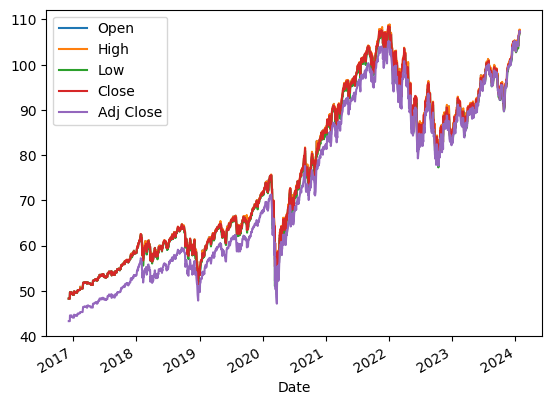

In [126]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_without_volume = df[cols[:5]]
df_for_plot=df_without_volume.tail(2000)
df_for_plot.index = train_dates.tail(2000)
df_for_plot.plot.line()



<Axes: xlabel='Date'>

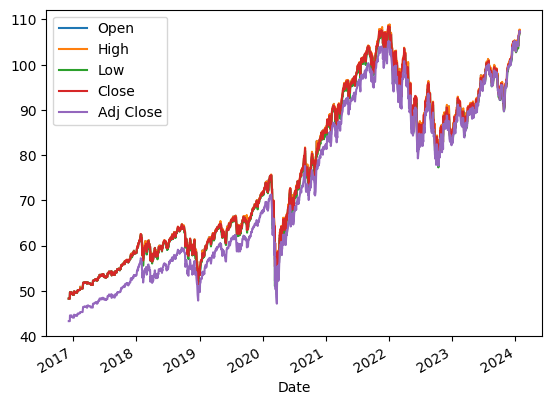

In [127]:
df_volume =  df[cols[-1]]
df_volume.index = train_dates.tail(2000)

df_for_plot.plot.line()


In [128]:
# df_for_training = df_for_training.iloc[:1200]

In [129]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)




In [130]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training).

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (1782, 14, 5).
trainY shape == (1782, 1).


In [131]:

#In my case, trainX has a shape (12809, 14, 5).
#12809 because we are looking back 14 days (12823 - 14 = 12809).
#Remember that we cannot look back 14 days until we get to the 15th day.
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but
#it needs multiple variables (5 in my example) to make this prediction.
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have.
#We need to predict all variables if we want to do that.

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 14, 64)            17920     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/15
101/101 [==============================] - 5s 18ms/step - loss: 0.1204 - val_loss: 0.0093
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0393 - val_loss: 0.0088
Epoch 3/15
101/101 [==============================] - 2s 25ms/step - loss: 0.0386 - val_loss: 0.0362
Epoch 4/15
101/101 [==============================] - 1s 14ms/step - loss: 0.0380 - val_loss: 0.0079
Epoch 5/15
101/101 [==============================] - 1s 14ms/step - loss: 0.0354 - val_loss: 0.0063
Epoch 6/15
101/101 [==============================] - 1s 14ms/step - loss: 0.0354 - val_loss: 0.0136
Epoch 7/15
101/101 [==============================] - 1s 14ms/step - loss: 0.0324 - val_loss: 0.0040
Epoch 8/15
101/101 [==============================] - 1s 14ms/step - loss: 0.0321 - val_loss: 0.0075
Epoch 9/15
101/101 [==============================] - 1s 14ms/step - loss: 0.0311 - val_loss: 0.0053
Epoch 10/15
101/101 [==============================] - 2s 17ms/step - loss: 0.0330 - val_lo

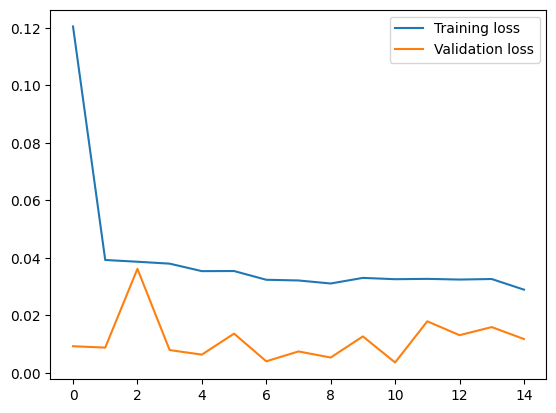

In [132]:

# fit the model
history = model.fit(trainX, trainY, epochs=15, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()



In [133]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)


[Timestamp('2024-01-04 00:00:00', freq='C'), Timestamp('2024-01-05 00:00:00', freq='C'), Timestamp('2024-01-08 00:00:00', freq='C'), Timestamp('2024-01-09 00:00:00', freq='C'), Timestamp('2024-01-10 00:00:00', freq='C'), Timestamp('2024-01-11 00:00:00', freq='C'), Timestamp('2024-01-12 00:00:00', freq='C'), Timestamp('2024-01-16 00:00:00', freq='C'), Timestamp('2024-01-17 00:00:00', freq='C'), Timestamp('2024-01-18 00:00:00', freq='C'), Timestamp('2024-01-19 00:00:00', freq='C'), Timestamp('2024-01-22 00:00:00', freq='C'), Timestamp('2024-01-23 00:00:00', freq='C'), Timestamp('2024-01-24 00:00:00', freq='C'), Timestamp('2024-01-25 00:00:00', freq='C')]


In [134]:

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]



1/1 [==============================] - 0s 285ms/step


In [135]:

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2016-12-6']

original

<ipython-input-135-9d5c036ac80e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


,Date,Close
0,2016-12-06,48.259998
1,2016-12-07,48.259998
2,2016-12-08,48.259998
3,2016-12-09,48.259998
4,2016-12-12,48.259998
...,...,...
1791,2024-01-22,106.570000
1792,2024-01-23,106.830002
1793,2024-01-24,106.870003
1794,2024-01-25,107.470001


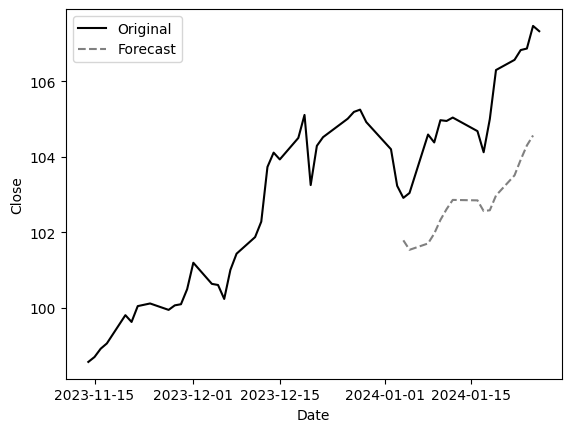

In [137]:
original_last_400 = original.iloc[-50:]
df_forecast_last_400 = df_forecast.iloc[-50:]

# Create the line plots
sns.lineplot(x='Date', y='Close', data=original_last_400,color = 'black', label='Original')
sns.lineplot(x='Date', y='Close', data=df_forecast_last_400, color = 'grey', linestyle='--',label='Forecast')

# Show the plot
plt.legend()  # This will add a legend to distinguish between the two lines
plt.show()